In [233]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.compose import ColumnTransformer
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

In [234]:
df = pd.read_csv("anaconda_projects/Housing.csv")
df.drop(columns=["mainroad","guestroom","basement","hotwaterheating","airconditioning","parking","prefarea"], inplace=True)
df.head()

,price,area,bedrooms,bathrooms,stories,furnishingstatus
0,13300000,7420,4,2,3,furnished
1,12250000,8960,4,4,4,furnished
2,12250000,9960,3,2,2,semi-furnished
3,12215000,7500,4,2,2,furnished
4,11410000,7420,4,1,2,furnished


In [235]:
# checking which column has null value more than 50%
df.isnull().sum() / len(df)

price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
furnishingstatus    0.0
dtype: float64

In [236]:
#low or high cardinality
df.select_dtypes("object").nunique()

furnishingstatus    3
dtype: int64

In [237]:
sorted(df.columns)

['area', 'bathrooms', 'bedrooms', 'furnishingstatus', 'price', 'stories']

<Axes: >

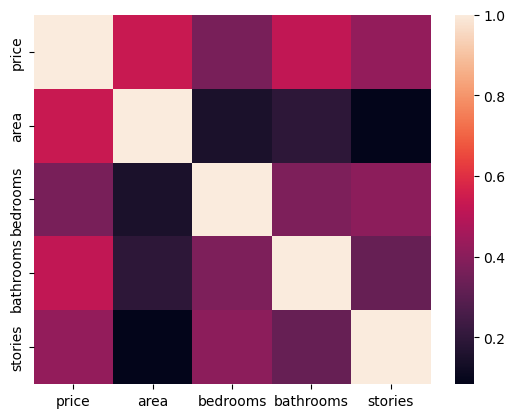

In [238]:
# to remove correlated columns
corr = df.select_dtypes("number").corr()
sns.heatmap(corr)

In [239]:
target = "price"
features = ["area","bedrooms","bathrooms","stories","furnishingstatus"]
y = df[target]
X = df[features]

cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]


In [240]:
#Calculate the baseline mean absolute error for the model.
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))


Mean apt price: 5277765.92
Baseline MAE: 1343599.8434475216


In [241]:
# Identify numerical and categorical features
num_features = ["area", "bedrooms", "bathrooms", "stories"]
cat_features = ["furnishingstatus"]  # Categorical feature

# Create transformers
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown="ignore")

# Combine transformations
preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

model = make_pipeline(
    preprocessor,
    SimpleImputer(),
    Ridge()
)

In [242]:
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['area', 'bedrooms',
                                                   'bathrooms', 'stories']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['furnishingstatus'])])),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [243]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 890817.31
Test MAE: 1287922.9


In [244]:
ridge_model = model.named_steps['ridge']
intercept = ridge_model.intercept_.round(2)
coefficient = ridge_model.coef_.round(2)[0]
print(f"Price = {intercept} + ({coefficient} * Features)")


Price = 5273627.59 + (701169.08 * Features)


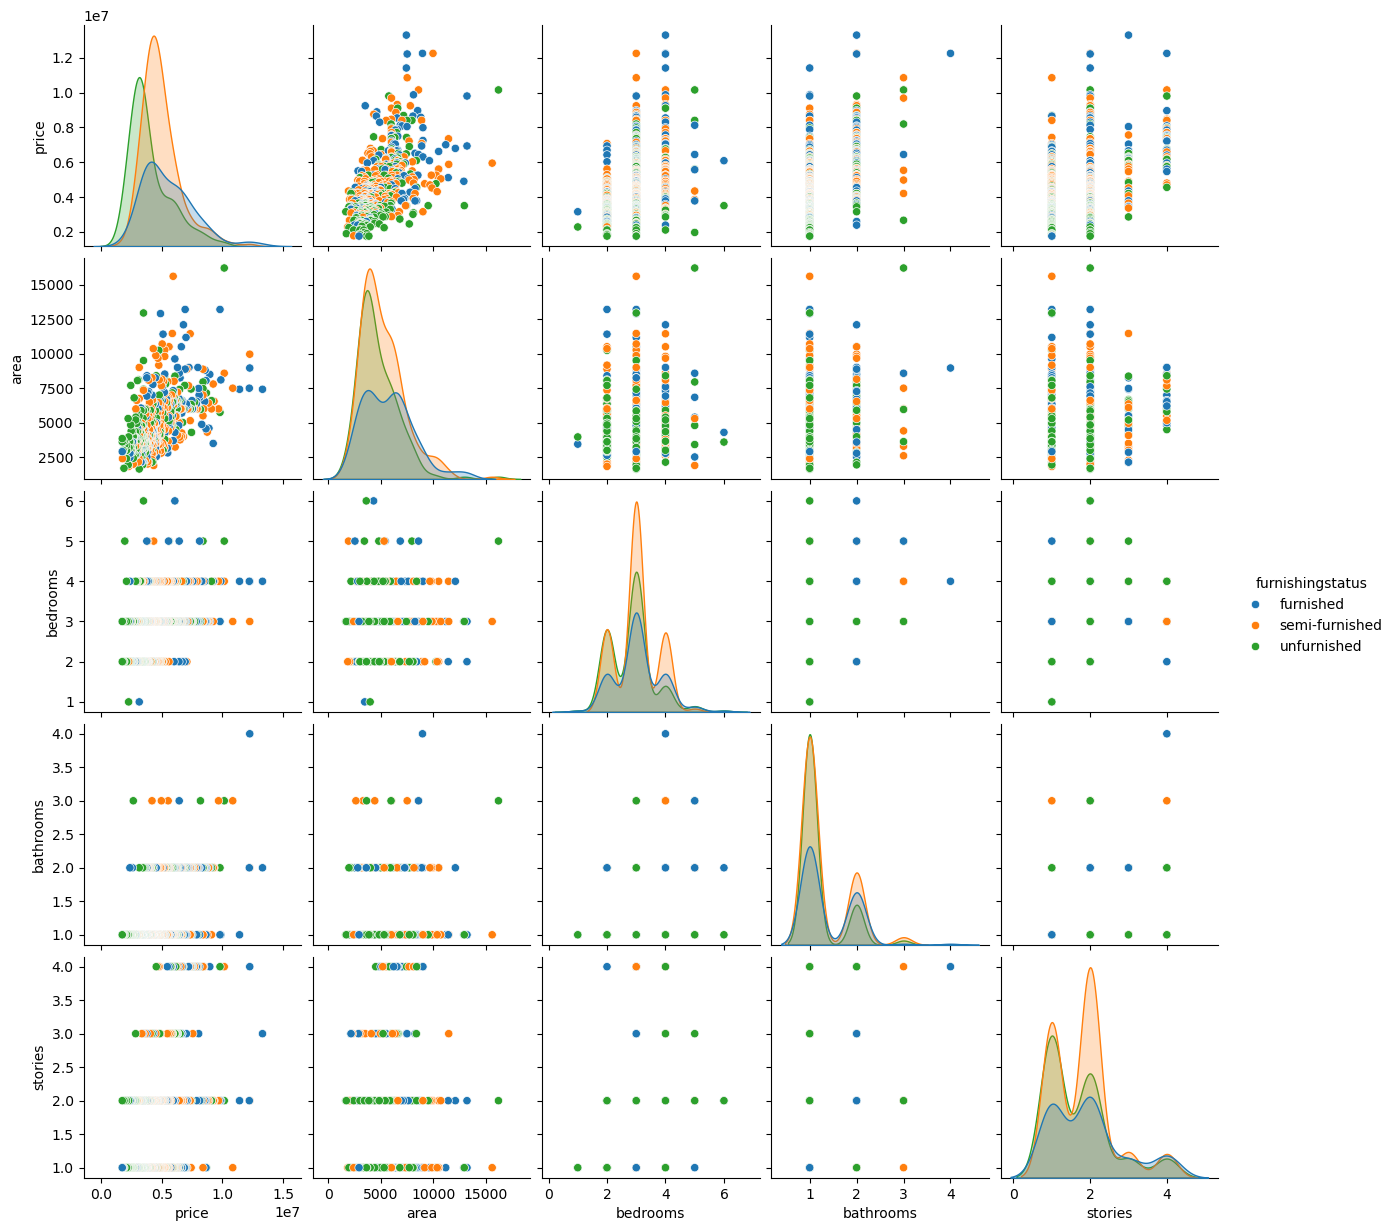

In [245]:
sns.pairplot(df, hue="furnishingstatus")
plt.show()

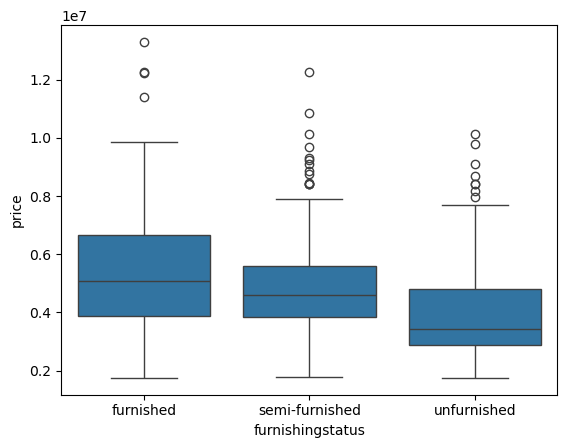

In [246]:
sns.boxplot(x="furnishingstatus", y="price", data=df)
plt.show()

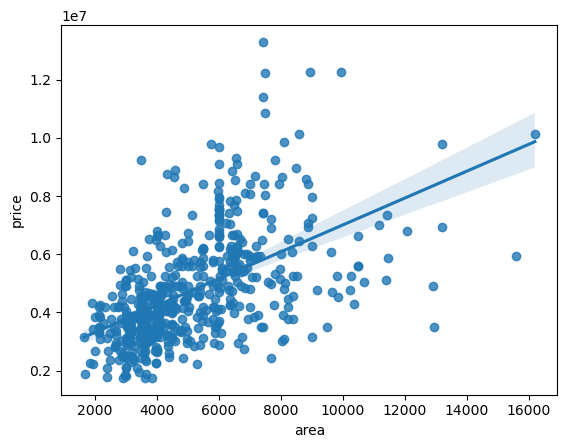

In [247]:
sns.regplot(x=df["area"], y=df["price"])
plt.show()

In [248]:
def make_prediction(area, bedrooms, bathrooms, stories,furnishingstatus):
    data ={
        "area": area,
        "bedrooms":bedrooms,
        "bathrooms":bathrooms,
        "stories":stories,
        "furnishingstatus":furnishingstatus
    }
    df =pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"


In [249]:
make_prediction(7420,2,3,2,"furnished")

'Predicted apartment price: $7822382.6'

In [275]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["area"].min(),
        max=X_train["area"].max(),
        value=X_train["area"].mean(),
    ),
    bedrooms=FloatSlider(
        min=X_train["bedrooms"].min(),
        max=X_train["bedrooms"].max(),
        step=0.01,
        value=X_train["bedrooms"].mean(),
    ),
    bathrooms=FloatSlider(
        min=X_train["bathrooms"].min(),
        max=X_train["bathrooms"].max(),
        step=0.01,
        value=X_train["bathrooms"].mean(),
    ),
    stories=FloatSlider(
        min=X_train["stories"].min(),
        max=X_train["stories"].max(),
        step=0.01,
        value=X_train["stories"].mean(),
    ),
    furnishingstatus=Dropdown(options=sorted(X_train["furnishingstatus"].unique())),
);


interactive(children=(IntSlider(value=5486, description='area', max=16200, min=1905), FloatSlider(value=3.0596…